In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl

import IPython.display as display

import numpy as np
import PIL.Image
import time
import functools

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [2]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]  # access the first matrix if (1, ..., ..., ...)
    return PIL.Image.fromarray(tensor)

In [3]:
# Get images from ./images
style_path = "images/vassily.jpg"

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

content_path = keras.utils.get_file(url.split('/')[-1], origin=url)

In [4]:
def load_image(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]  # creates another dimension (1, ..., ..., 3)
    
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

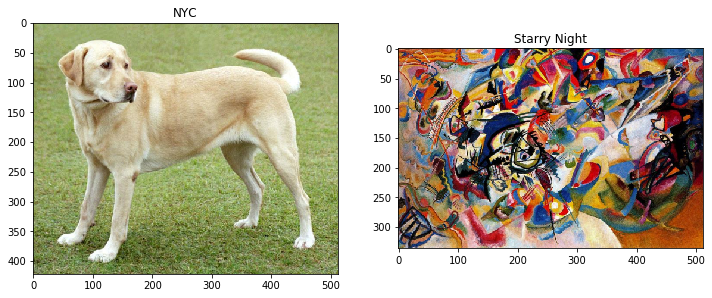

In [6]:
content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, title="NYC")

plt.subplot(1, 2, 2)
imshow(style_image, title="Starry Night")

In [7]:
# Choose intermediate layers to represent the content and style for the generated image
content_layers = ["block4_conv2"]

style_layers = ["block1_conv1",
               "block2_conv1",
               "block3_conv1",
               "block4_conv1",
               "block5_conv1"]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def vgg_layers(layer_names):
    # Returns a list of layer_names and their outputs
    vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False  # freeze layers
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = keras.Model([vgg.input], outputs)
    return model

In [9]:
# Compute style by using Gram Matrix (outer product of itself generates correlation matrix)
def gram_matrix(input_tensor):
    # matrix of size (b,i,j,c) dot (b,i,j,d).T = (b,c,d) or n_C * (n_H * n_W) dot (n_H * n_W) * n_C = n_C x n_C
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    
    # input_shape[1], input_shape[2] = n_H, n_W
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    return result / num_locations

In [10]:
# Class the returns the style in gram matrix and content of the image
class StyleContentModel(keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        # Expects input image of float [0, 1]
        inputs = inputs*255.0
        preprocessed_inputs = keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_inputs)
    
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [11]:
extractor = StyleContentModel(style_layers, content_layers)

# results = extractor(tf.constant(content_image))

# print("Style: ")
# for name, output in sorted(results['style'].items()):
#     print(f"  {name}")
#     print(f"  shape: {output.numpy().shape}")
#     print(f"  min: {output.numpy().min()}")
#     print(f"  max: {output.numpy().max()}")
#     print(f"  mean: {output.numpy().mean()}")
#     print()
    
# print("Content: ")
# for name, output in sorted(results['content'].items()):
#     print(f"  {name}")
#     print(f"  shape: {output.numpy().shape}")
#     print(f"  min: {output.numpy().min()}")
#     print(f"  max: {output.numpy().max()}")
#     print(f"  mean: {output.numpy().mean()}")
#     print()

In [12]:
# Get target style and target content using by running the images through the extractor
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [13]:
# Initialize a generated image of the same size as the content_image, to optimzie make it a Variable
# and to make it quicker, initialize it as the content_image
image = tf.Variable(content_image)

In [14]:
# Since the image is a float image, clip values to be [0, 1]
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [64]:
# Create an optimizer, paper uses LBFGS but Adam works fine
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [16]:
# Set weighted values of content and style to appear in the generated image
style_weight = 1e4
content_weight = 1e-2

In [17]:
def style_content_loss(outputs, content_targets, style_targets, content_weight, style_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])  # squared supposed to be inside reduce_mean to be sum of difference squared
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                            for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    return loss

In [18]:
# Reset image
image = tf.Variable(content_image)

In [19]:
# Regularization weight to reduce high frequency variations / artifacts
total_variation_weight = 30

In [20]:
# Record operations to calculate automatic differentiation (ie. 1 step of gradient descent)
def train_step(image, content_targets, style_targets, content_weight, style_weight, total_variation_weight):
    with tf.GradientTape() as tape:
        outputs = extractor(image)  # pass generated image into the network and get outputs
        
        # calculate the loss function
        loss = style_content_loss(outputs, content_targets, style_targets, content_weight, style_weight)
        loss += total_variation_weight * tf.image.total_variation(image)
        
    grad = tape.gradient(loss, image)  # loss will be differentiated against the pixels in image
    opt.apply_gradients([(grad, image)])  # apply grads calculated to image
    image.assign(clip_0_1(image))  # assign image to a new clipped image after applying gradients
    
    return loss

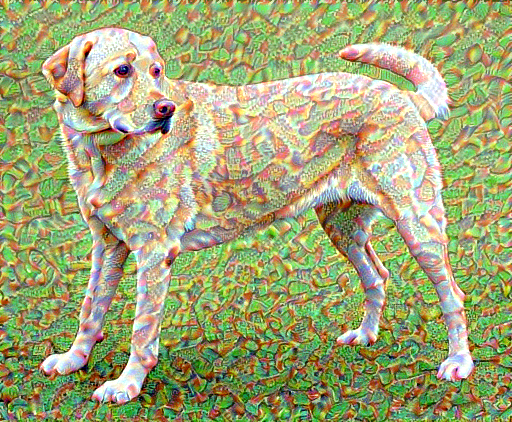

In [25]:
train_step(image, content_targets, style_targets, 1e-2, 1e4, 0)
train_step(image, content_targets, style_targets, 1e-2, 1e4, 0)
train_step(image, content_targets, style_targets, 1e-2, 1e4, 0)
tensor_to_image(image)

In [55]:
def train(image, epochs, content_targets, style_targets, content_weight, style_weight, total_variation_weight, steps_per_epoch=100):
    step = 0
    display.display(tensor_to_image(image))
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            loss = train_step(image, content_targets, style_targets, content_weight, style_weight, total_variation_weight)
            
            if step % 1 == 0:
                display.clear_output(wait=True)
                display.display(tensor_to_image(image))
                print(f"Training step: {step}, Loss: {loss}")
    
    return image

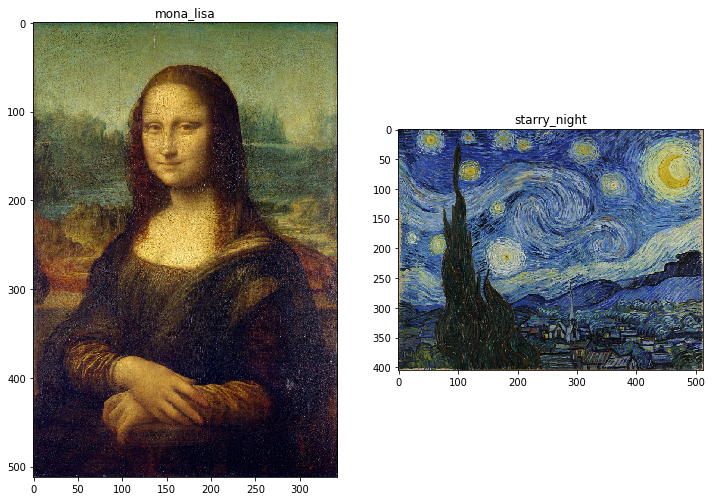

In [96]:
# content_path = "images/turtle.jpg"
style_path = "images/starry_night.jpg"

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
labrador = keras.utils.get_file(url.split('/')[-1], origin=url)

content_path = "images/mona_lisa.jpg"

# Get image from its respective paths
content_image = load_image(content_path)
style_image = load_image(style_path)

# Display images to be synthesized
plt.subplot(1, 2, 1)
imshow(content_image, title=content_path.split('/')[-1][:-4])

plt.subplot(1, 2, 2)
imshow(style_image, title=style_path.split('/')[-1][:-4])

In [73]:
def NST(content_image, style_image, reset=True, epochs=10, steps_per_epoch=1, content_weight=1e4, style_weight=0.02, total_variation_weight=30):
    # Extract target content and styles
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    
    # Initialize image
    if reset:
        image = tf.Variable(content_image)
    else:
        noise = np.random.uniform(-20, 20, tf.shape(content_image)).astype('float32')
        image  = noise * 0.6 + content_image * (1 - noise)
        image = tf.Variable(image)
        
    # Start training
    image = train(image, epochs, content_targets, style_targets, content_weight, style_weight, total_variation_weight, steps_per_epoch=steps_per_epoch)
    
    return image

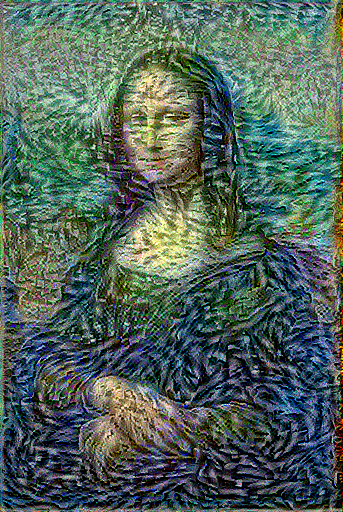

Training step: 87, Loss: [8.4438936e+12]


KeyboardInterrupt: 

In [97]:
image = NST(content_image, style_image, epochs=1, reset=True, steps_per_epoch=140, content_weight=1e4, style_weight=1e-2, total_variation_weight=30)

In [94]:
file_name='Tuebingen_Afremov.jpg'
tensor_to_image(image).save(file_name)